# 作業 : (Kaggle)房價預測

# [作業目標]
- 試著模仿範例寫法, 在房價預測中, 觀察去除離群值的影響

# [作業重點]
- 觀察將極端值以上下限值取代, 對於分布與迴歸分數的影響 (In[5], Out[5])
- 觀察將極端值資料直接刪除, 對於分布與迴歸分數的影響 (In[6], Out[6])

In [1]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler #數據預處理-利用最大值和最小值進行0~1間的縮放
from sklearn.model_selection import cross_val_score #用交叉驗證法來計算模型得分，以驗證模型的表現
from sklearn.linear_model import LinearRegression #擬合數據用

df_train = pd.read_csv('/Users/mikali/Documents/GitHub/mydata/Part02/house_train.csv.gz')
# print(df_train)

train_Y = np.log1p(df_train['SalePrice'])
# print(train_Y)

df = df_train.drop(['Id', 'SalePrice'] , axis=1)
df.head()

# np.log1p()用來對數據進行轉化、壓縮到一個區間裡，使其更貼近高斯分佈，此步處理可能會讓之後的分類得到一個好的結果


/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:996: UserWarning: Illegal line #1
	"i#### MATPLOTLIBRC FORMAT
"
	in file "/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:996: UserWarning: Illegal line #69
	"f
"
	in file "/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [2]:
#只取出資料類型是 int64 或 float64 的欄位
num_features = []
for dtype,feature in zip(df.dtypes,df.columns):
    if dtype =='int64' or dtype =='float64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Feature:{num_features}\n')  # f-string 新用法

36 Numeric Feature:['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [3]:
# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)  #將空格用Na或NaN填滿
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# 作業1
* 試著限制 '1樓地板面積(平方英尺)' (1stFlrSF) 欄位的上下限, 看看能否再進一步提高分數?

In [4]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns  #為matplotlib 基礎建構的高階繪圖套件，補matplotlib的不足
import matplotlib.pyplot as plt

sns.regplot(x = df['1stFlrSF'], y=train_Y)  #.regplot()迴歸分析繪圖函數
plt.show()


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 640x480 with 1 Axes>

In [5]:
a = df["1stFlrSF"].quantile(0)
b = df["1stFlrSF"].quantile(0.2)
c = df["1stFlrSF"].quantile(0.5)
d = df["1stFlrSF"].quantile(0.8)
e = df["1stFlrSF"].quantile(1)

print(f'quantile(0): {a}')
print(f'quantile(0.2): {b}')
print(f'quantile(0.5): {c}')
print(f'quantile(0.8): {d}')
print(f'quantile(1): {e}')

quantile(0): 334.0
quantile(0.2): 848.0
quantile(0.5): 1087.0
quantile(0.8): 1482.4
quantile(1): 4692.0


/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Noto Sans CJK TC'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


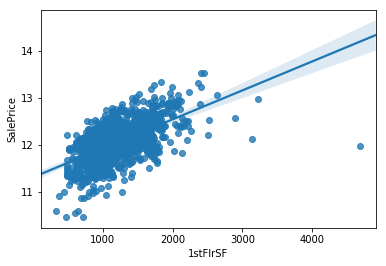

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


cross_val_score: 0.8499092569205354


In [6]:
# < 一、調整離值群 >
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
df['1stFlrSF'] = df['1stFlrSF'].clip(a,e)
sns.regplot(x = df['1stFlrSF'], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數:
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
f = cross_val_score(estimator, train_X, train_Y, cv=5).mean()


print(f'cross_val_score: {f}')
#cross_val_score用來評分資料準確度，意思是會將資料分成多組訓練資料+測試資料的組合，重複跑之後取平均，避免模型只考慮特定的資料組合。因此，重複的結果不同，可能是因為每次曲道的組合有差異。
#cv=5 表示分成5組

# 作業2
* 續前題, 去除離群值有兩類方式 :  捨棄離群值(刪除離群的資料) 以及調整離群值,  
請試著用同樣的上下限, 改為 '捨棄離群值' 的方法, 看看結果會變好還是變差? 並試著解釋原因。

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


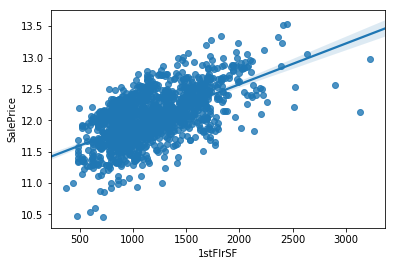

cross_val_score: 0.8804335972776329


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [7]:
# < 二、捨棄離群值 >
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值
keep_indexs = (df['1stFlrSF']> a) & (df['1stFlrSF']< e)
df = df[keep_indexs]
train_Y = train_Y[keep_indexs]
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
print(f'cross_val_score: {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}')

#### 結論：使用"捨棄離群值"，能得到較高的模型驗證分數。從圖中看到離群值的數量很少，因此捨棄離群值能使提高模型表現。